# Seq2Seq 기계 번역

이번 프로젝트에선 임의로 Seq2Seq 모델을 아주 간단화 시켰습니다.
한 언어로 된 문장을 다른 언어로 된 문장으로 번역하는 덩치가 큰 모델이 아닌
영어 알파벳 문자열("hello")을 스페인어 알파벳 문자열("hola")로 번역하는 Mini Seq2Seq 모델을 같이 구현해 보겠습니다.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt #시각화

In [2]:
# 기본적으로는 문장을 넣기 때문에 Word Embedding을 진행하지만,
# 이 예제에서는 철자 하나씩에 대한 Character Embedding을 수행
vocab_size = 256  # 영문만 다루기 때문에, 영문에 대한 총 아스키 코드 개수
x_ = list(map(ord, "hello"))  # 아스키 코드 리스트로 변환
y_ = list(map(ord, "hola"))   # 아스키 코드 리스트로 변환
# x : 원문 / y : 번역문
print("hello -> ", x_)
print("hola  -> ", y_)

hello ->  [104, 101, 108, 108, 111]
hola  ->  [104, 111, 108, 97]


In [3]:
# 모델 입력을 위해 Tensor형태로 변환
x = torch.LongTensor(x_)
y = torch.LongTensor(y_)

In [4]:
class Seq2Seq(nn.Module):
    def __init__(self, vocab_size, hidden_size):
        super(Seq2Seq, self).__init__()
        self.n_layers = 1 # 간단하니깐 
        # hidden_size : 이번 예제에서는 별도의 값이 아닌, 임베딩된 토큰의 차원값과 동일히 정의
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocab_size, hidden_size)
        self.encoder = nn.GRU(hidden_size, hidden_size)# 인코더 정의
        self.decoder = nn.GRU(hidden_size, hidden_size)# 디코더 정의
        self.project = nn.Linear(hidden_size, vocab_size)# 디코더가 번역문의 다음 토큰을 예상하는 Linear layer 정의

    def forward(self, inputs, targets):
        # 인코더에 들어갈 입력 임베딩
        initial_state = self._init_state()
        embedding = self.embedding(inputs).unsqueeze(1)
        # embedding 형태: [seq_len, batch_size, embedding_size]
        
        # 인코더 (Encoder)
        encoder_output, encoder_state = self.encoder(embedding, initial_state)
        # encoder_output = [seq_len, batch_size, hidden_size]
        # encoder_state : 인코더의 context vector [n_layers, seq_len, hidden_size]

        # 디코더에 들어갈 입력을 인코더의 context vector로 지정
        decoder_state = encoder_state
        decoder_input = torch.LongTensor([0])# 문장의 시작을 위해서 NULL을 의미하는 [0]으로 설정
        
        # 디코더 (Decoder)
        outputs = []
        
        for i in range(targets.size()[0]):
            decoder_input = self.embedding(decoder_input).unsqueeze(1)#임베딩 및 사이즈 맞추기 위해서 unsqueeze

            # decoder 입력 : 초기 문장 시작(NULL), Encoder의 context vector
            decoder_output, decoder_state = self.decoder(decoder_input, decoder_state)

            # 디코더의 출력값으로 다음 글자 예측
            projection = self.project(decoder_output)
            outputs.append(projection)
            
            # 티처 포싱(Teacher Forcing) 사용
            # 디코더 학습 시 실제 번역문의 토큰을 디코더의 전 출력값 대신 입력으로 사용
            decoder_input = torch.LongTensor([targets[i]])

        # output : 모든 토큰에 대한 결괏값들의 배열
        outputs = torch.stack(outputs).squeeze()
        return outputs
    
    def _init_state(self, batch_size=1):
        weight = next(self.parameters()).data
        return weight.new(self.n_layers, batch_size, self.hidden_size).zero_()

In [5]:
# 모델 선언(Vocab_SIZE, hidden feature size)
seq2seq = Seq2Seq(vocab_size, 16)

In [6]:
# Loss : cross entropy loss
# Optimizer : Adam
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(seq2seq.parameters(), lr=1e-3)

In [7]:
log = []
for i in range(1000):
    prediction = seq2seq(x, y)
    loss = criterion(prediction, y)
    optimizer.zero_grad()# Optimizer 매번 계산하니깐 zero로 설정
    
    loss.backward()
    optimizer.step()

    loss_val = loss.data
    log.append(loss_val)
    # 100 에폭마다 출력
    if i % 100 == 0:
        print("\n 반복:%d 오차: %s" % (i, loss_val.item()))
        _, top1 = prediction.data.topk(1, 1)
        print([chr(c) for c in top1.squeeze().numpy().tolist()])


 반복:0 오차: 5.5274858474731445
['\x0c', '\x92', 'Ê', 'C']

 반복:100 오차: 1.9710159301757812
['h', 'o', 'l', 'a']

 반복:200 오차: 0.5529958605766296
['h', 'o', 'l', 'a']

 반복:300 오차: 0.2716451585292816
['h', 'o', 'l', 'a']

 반복:400 오차: 0.17074677348136902
['h', 'o', 'l', 'a']

 반복:500 오차: 0.12089813500642776
['h', 'o', 'l', 'a']

 반복:600 오차: 0.09064405411481857
['h', 'o', 'l', 'a']

 반복:700 오차: 0.0704270675778389
['h', 'o', 'l', 'a']

 반복:800 오차: 0.05638203024864197
['h', 'o', 'l', 'a']

 반복:900 오차: 0.04618227109313011
['h', 'o', 'l', 'a']


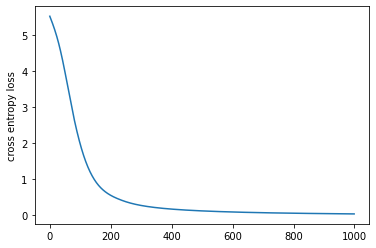

In [8]:
# 학습이 지나면서 Loss가 줄어드는 것 확인 가능
plt.plot(log)
plt.ylabel('cross entropy loss')
plt.show()